### PyramidNets
#### ResNet
ResNetなどでは、特徴マップのサイズが減少するタイミングでチャネル数を増加させていた。  
ResNetでは、$n$番目のグループの$k$番目のresidualユニットにおける特徴マップのチャネル数$D_k$は、

$$
D_k=\left\{\begin{array}{ll}
16&n(k)=1\\
16・2^{n(k)-2}&n(k)\geq1
\end{array}\right.
$$

ここで、$n(k)\in\{1,2,3,4\}$は、$k$番目のresidualユニットが属するグループのインデックスを表している。   
同じグループに属しているユニットの特徴マップは同じサイズであり、$n$番目のグループは$N_n$個のユニットを含むものとする。  
1番目のグループは、RGB画像を複数のチャネルに変換する1つの畳み込み層からなる。  
n番目のグループでは、$N_n$個のユニットを通して特徴マップのサイズは半分に、チャネル数は2倍となる。  
  
#### additive PyramidNet
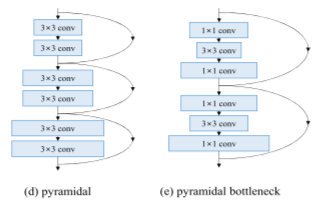
$$
D_k=\left\{\begin{array}{ll}
16&k=1\\
\lfloor D_{k-1}+\alpha/N\rfloor &2\leq k\leq N+1
\end{array}\right.
$$

ここで、$N$はresidualユニットの総数であり、
$$
N=\sum_{n=2}^4N_n
$$
である。
チャネル数は$\alpha / N$ずつ増加、各グループのユニット数が同じであれば各グループの最後のユニットでのチャネル数は$16+(n-1)\alpha/3$と計算できる。  
$\alpha$はどの程度チャネル数を増加させるかを表す因子である。  
また、$\lfloor　\rfloor$は床関数と呼ばれるもので、その値を超えない整数を表す。

#### multiplicative PyramidNet
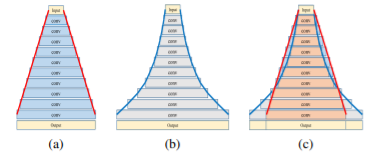
$$
D_k=\left\{\begin{array}{ll}
16&k=1\\
\lfloor D_{k-1}・\alpha^{1/N}\rfloor &2\leq k\leq N+1
\end{array}\right.
$$

additiveのものと比べ、input側ではチャネル数はゆっくり変化するが、outputに近くなるほど急に変化する。  
  
すべてのユニットでチャネル数が増加するので、shortcut connectionではzero-paddingでチャネル数を合わせる。

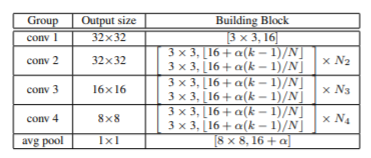

ここでは、bottleneckで、$N=272(N_n=(272-2)/9=30)$で$\alpha=200$のものを実装する。  
inputは1層目で16チャネルに変換され、ユニットを通るごとに$200/90$ずつ増加していく。  
各グループで(66～67)×4チャネルずつ増加し、最終的には(16+200)×4=864チャネルとなる。

さらに、baseのもので$N=110(N_n=(110-2)/6=18)$で$\alpha=270$のものを実装する。

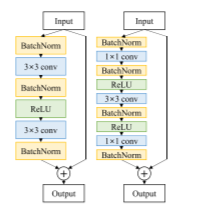

#### 学習
最適化手法はSGD(Nesterov)で学習率は0.1、エポック数が150と225のときに0.1を掛けて小さくしていく。  
weight decayは0.0001、 momentumを0.9に設定し、バッチサイズは128とする。

In [14]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [52]:
class res_bottleneck_block(Model):
    """wide residual block"""
    def __init__(self, block_num, layer_num, Nn, N, alpha):
        super(res_bottleneck_block, self).__init__(name='block'+'_'+str(block_num)+'_'+str(layer_num))        
        block_name = '_'+str(block_num)+'_'+str(layer_num)
        
        # shortcutとstrideの設定
        self._is_change=False
        if (layer_num == 0):
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
            else:
                stride = 2
                self._is_change=True
        else:
            stride = 1

        self.maxpooling=MaxPooling2D(pool_size=(stride, stride), strides=(stride, stride), padding='valid')

        bneck_channels = np.ceil(16+(Nn*(block_num-1)+layer_num+1)*alpha/N)
        out_channels = bneck_channels*4
        
        self.bn0 = BatchNormalization(name='bn0'+block_name)
        
        # 1層目 1×1 畳み込み処理は行わず(線形変換)、チャネル数をbneck_channelsにします
        self.conv1 = Conv2D(bneck_channels, kernel_size=1, strides=1, padding='valid', use_bias=False, name='conv1'+block_name)
        self.bn1 = BatchNormalization(name='bn1'+block_name)
        self.act1 = Activation('relu', name='act1'+block_name)
        
        # 2層目 3×3 畳み込み処理を行います
        self.conv2 = Conv2D(bneck_channels, kernel_size=3, strides=stride, padding='same', use_bias=False, name='conv2'+block_name)
        self.bn2 = BatchNormalization(name='bn2'+block_name)
        self.act2 = Activation('relu', name='act2'+block_name)
        
        # 3層目 1×1 畳み込み処理は行わず(線形変換)、チャネル数をout_channelsにします
        self.conv3 = Conv2D(out_channels, kernel_size=1, strides=1, padding='valid', use_bias=False, name='conv3'+block_name)
        self.bn3 = BatchNormalization(name='bn3'+block_name)
        
        self.add = Add(name='add'+block_name)
        
    def call(self, x):
        out = self.bn0(x)
        
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.act1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.act2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)

        if K.int_shape(x) != K.int_shape(out):
            if self._is_change:
                x = self.maxpooling(x)
            if K.int_shape(x)[3] != K.int_shape(out)[3]:                
                x = tf.pad(x, [[0, 0], [0, 0], [0, 0], [0, K.int_shape(out)[3] - K.int_shape(x)[3]]])

            shortcut = x
        else:
            shortcut = x
        
        out = self.add([out, shortcut])
        return out

In [53]:
class res_base_block(Model):
    """wide residual block"""
    def __init__(self, block_num, layer_num, Nn, N, alpha):
        super(res_base_block, self).__init__(name='block'+'_'+str(block_num)+'_'+str(layer_num))        
        block_name = '_'+str(block_num)+'_'+str(layer_num)
        
        # shortcutとstrideの設定
        self._is_change=False
        if (layer_num == 0):
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
            else:
                stride = 2
                self._is_change=True
        else:
            stride = 1

        self.maxpooling=MaxPooling2D(pool_size=(stride, stride), strides=(stride, stride), padding='valid')

        out_channels = np.ceil(16+(Nn*(block_num-1)+layer_num+1)*alpha/N)
        
        self.bn0 = BatchNormalization(name='bn0'+block_name)
        
        # 1層目 3×3 畳み込み処理は行わず(線形変換)、チャネル数をbneck_channelsにします
        self.conv1 = Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=False, name='conv1'+block_name)
        self.bn1 = BatchNormalization(name='bn1'+block_name)
        self.act1 = Activation('relu', name='act1'+block_name)
        
        # 2層目 3×3 畳み込み処理を行います
        self.conv2 = Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False, name='conv2'+block_name)
        self.bn2 = BatchNormalization(name='bn2'+block_name)
        
        self.add = Add(name='add'+block_name)
        
    def call(self, x):
        out = self.bn0(x)
        
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.act1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        if K.int_shape(x) != K.int_shape(out):
            if self._is_change:
                x = self.maxpooling(x)
            if K.int_shape(x)[3] != K.int_shape(out)[3]:                
                x = tf.pad(x, [[0, 0], [0, 0], [0, 0], [0, K.int_shape(out)[3] - K.int_shape(x)[3]]])

            shortcut = x
        else:
            shortcut = x
        
        out = self.add([out, shortcut])
        return out

In [54]:
class PyramidNet(Model):
    def __init__(self,alpha = 200, N = 272, block=res_base_block):
        super(PyramidNet, self).__init__()
        self._layers = []
        
        if block == res_bottleneck_block:
            Nn = (N-2)//9
            N_all = N//3
        else:
            Nn = (N-2)//6
            N_all = N//2
            
        # 入力層
        self._layers += [
            Conv2D(filters = 16, kernel_size = (3,3), strides = 1, padding = 'same', name='conv_input'),
            BatchNormalization(name='bn_input'),
            Activation('relu', name='act_input')
        ]

        # Residualブロック
        self._layers += [block(block_num=1, layer_num=k, Nn=Nn, N=N_all, alpha=alpha) for k in range(Nn)]
        self._layers += [block(block_num=2, layer_num=k, Nn=Nn, N=N_all, alpha=alpha) for k in range(Nn)]
        self._layers += [block(block_num=3, layer_num=k, Nn=Nn, N=N_all, alpha=alpha) for k in range(N_all-2*Nn)]
        
        # 出力層
        self._layers += [
            GlobalAveragePooling2D(name='pool_output'),
            Dense(10, activation='softmax', name='output')
        ]
    
    def call(self, x):
        for layer in self._layers:
            #print(layer)
            x = layer(x)
        return x

In [55]:
#model = PyramidNet(alpha = 270, N = 110, block=res_base_block)
model = PyramidNet(block=res_bottleneck_block)
model.build((None, 32, 32, 3))  # build with input shape.
dummy_input = Input(shape=(32, 32, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input), name="pretrained")
model_summary.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_input (Conv2D)          (None, 32, 32, 16)        448       
__________________________________________________

block_2_19 (res_bottleneck_b (None, 16, 16, 512)       282064    
_________________________________________________________________
block_2_20 (res_bottleneck_b (None, 16, 16, 520)       291428    
_________________________________________________________________
block_2_21 (res_bottleneck_b (None, 16, 16, 528)       300400    
_________________________________________________________________
block_2_22 (res_bottleneck_b (None, 16, 16, 536)       309508    
_________________________________________________________________
block_2_23 (res_bottleneck_b (None, 16, 16, 544)       318752    
_________________________________________________________________
block_2_24 (res_bottleneck_b (None, 16, 16, 556)       332301    
_________________________________________________________________
block_2_25 (res_bottleneck_b (None, 16, 16, 564)       342457    
_________________________________________________________________
block_2_26 (res_bottleneck_b (None, 16, 16, 572)       352177    
__________

In [321]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.1
    if epoch >= 150:
        x = 0.1*0.1
    if epoch >= 225:
        x = 0.1*(0.1**2)
    return x


lr_decay = LearningRateScheduler(
    lr_schedul,
    verbose=1,
)

sgd = SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=True)
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [31]:
class res_bottleneck_block(nn.Module):
    """residual block"""
    def __init__(self, block_num, layer_num, Nn, N, alpha):
        super(res_bottleneck_block, self).__init__()
        
        # 1番目のブロック以外はチャンネル数がinputとoutputで変わる(output=4×input)
        input_channels = int(np.floor(16+(Nn*(block_num-1)+layer_num)*alpha/N)*4)
        
        bneck_channels = int(np.floor(16+(Nn*(block_num-1)+layer_num+1)*alpha/N))
        out_channels = int(bneck_channels*4)
        
        # shortcutとstrideの設定
        self._is_change = False
        if (layer_num == 0):
            input_channels=int(np.floor(16+(Nn*(block_num-2)+Nn)*alpha/N)*4)
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
                input_channels=16
            else:
                self._is_change = True
                self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
                stride = 2
        else:
            stride = 1
        
        self.pad_channels = out_channels - input_channels
        
        self.bn0 = nn.BatchNorm2d(input_channels)
        
        # 1層目 1×1 畳み込み処理は行わず(線形変換)、チャネル数をbneck_channelsにします
        self.conv1 = nn.Conv2d(input_channels, bneck_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(bneck_channels)
        
        # 2層目 3×3 畳み込み処理を行います
        self.conv2 = nn.Conv2d(bneck_channels, bneck_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(bneck_channels)
        
        # 3層目 1×1 畳み込み処理は行わず(線形変換)、チャネル数をout_channelsにします
        self.conv3 = nn.Conv2d(bneck_channels, out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
                
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        shortcut = x
        
        out = self.bn0(x)
        
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        # Projection shortcutの場合
        if self._is_change:
            shortcut = self.maxpool(shortcut)

        p3d = (0, 0, 0, 0, 0, self.pad_channels) # pad by (0, 1), (2, 1), and (3, 3)
        shortcut = torch.nn.functional.pad(shortcut, p3d, "constant", 0)
        
        out += shortcut
        out = self.relu(out)

        return out

In [38]:
class res_base_block(nn.Module):
    """residual block"""
    def __init__(self, block_num, layer_num, Nn, N, alpha):
        super(res_base_block, self).__init__()
        
        # 1番目のブロック以外はチャンネル数がinputとoutputで変わる(output=4×input)
        input_channels = int(np.ceil(16+(Nn*(block_num-1)+layer_num)*alpha/N))
        
        out_channels = int(np.ceil(16+(Nn*(block_num-1)+layer_num+1)*alpha/N))
        
        # shortcutとstrideの設定
        self._is_change = False
        if (layer_num == 0):
            input_channels=int(np.ceil(16+(Nn*(block_num-2)+Nn)*alpha/N))
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
                input_channels=16
            else:
                self._is_change = True
                self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
                stride = 2
        else:
            stride = 1
        
        self.pad_channels = out_channels - input_channels
        print(block_num,input_channels,out_channels)
        
        self.bn0 = nn.BatchNorm2d(input_channels)
        
        # 1層目 1×1 畳み込み処理は行わず(線形変換)、チャネル数をbneck_channelsにします
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 2層目 3×3 畳み込み処理を行います
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
                
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        shortcut = x
        
        out = self.bn0(x)
        
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Projection shortcutの場合
        if self._is_change:
            shortcut = self.maxpool(shortcut)

        p3d = (0, 0, 0, 0, 0, self.pad_channels) # pad by (0, 1), (2, 1), and (3, 3)
        shortcut = torch.nn.functional.pad(shortcut, p3d, "constant", 0)
        out += shortcut
        out = self.relu(out)

        return out

In [44]:
class PyramidNet(nn.Module):
    def __init__(self,alpha = 200, N = 272, num_classes=10, block=res_base_block):
        super(PyramidNet, self).__init__()
        
        if block == res_bottleneck_block:
            Nn = (N-2)//9
            N_all = N//3
            in_features = int((16 + alpha)*4)
        else:
            Nn = (N-2)//6
            N_all = N//2
            in_features = 16 + alpha
        
        conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        bn1 = nn.BatchNorm2d(16)
        relu1 = nn.ReLU(inplace=True)
        
        self.conv1 = nn.Sequential(*[conv1, bn1, relu1])
        
        self.conv2_x = nn.Sequential(*[block(block_num=1, layer_num=k, Nn=Nn, N=N_all, alpha=alpha) for k in range(Nn)])
        self.conv3_x = nn.Sequential(*[block(block_num=2, layer_num=k, Nn=Nn, N=N_all, alpha=alpha) for k in range(Nn)])
        self.conv4_x = nn.Sequential(*[block(block_num=3, layer_num=k, Nn=Nn, N=N_all, alpha=alpha) for k in range(N_all-2*Nn)])
        
        pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(*[pool])
        #int(np.floor(16+(Nn*(block_num-1)+layer_num)*alpha/N))
        self.linear = nn.Linear(in_features=in_features, out_features=num_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.fc(out)
        out = out.view(out.shape[0], -1)
        out = self.linear(out)
        
        return out

In [45]:
summary(PyramidNet(alpha = 270, N = 110, block=res_base_block), (3,32,32))

1 16 21
1 21 26
1 26 31
1 31 36
1 36 41
1 41 46
1 46 51
1 51 56
1 56 61
1 61 66
1 66 70
1 70 75
1 75 80
1 80 85
1 85 90
1 90 95
1 95 100
1 100 105
2 105 110
2 110 115
2 115 120
2 120 124
2 124 129
2 129 134
2 134 139
2 139 144
2 144 149
2 149 154
2 154 159
2 159 164
2 164 169
2 169 174
2 174 178
2 178 183
2 183 188
2 188 193
3 193 198
3 198 203
3 203 208
3 208 213
3 213 218
3 218 223
3 223 228
3 228 232
3 232 237
3 237 242
3 242 247
3 247 252
3 252 257
3 257 262
3 262 267
3 267 272
3 272 277
3 277 282
3 282 286
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 21, 32, 32]           3,045
       BatchNorm2d-6           [-1

          Conv2d-117           [-1, 90, 32, 32]          68,940
     BatchNorm2d-118           [-1, 90, 32, 32]             180
            ReLU-119           [-1, 90, 32, 32]               0
          Conv2d-120           [-1, 90, 32, 32]          72,990
     BatchNorm2d-121           [-1, 90, 32, 32]             180
            ReLU-122           [-1, 90, 32, 32]               0
  res_base_block-123           [-1, 90, 32, 32]               0
     BatchNorm2d-124           [-1, 90, 32, 32]             180
          Conv2d-125           [-1, 95, 32, 32]          77,045
     BatchNorm2d-126           [-1, 95, 32, 32]             190
            ReLU-127           [-1, 95, 32, 32]               0
          Conv2d-128           [-1, 95, 32, 32]          81,320
     BatchNorm2d-129           [-1, 95, 32, 32]             190
            ReLU-130           [-1, 95, 32, 32]               0
  res_base_block-131           [-1, 95, 32, 32]               0
     BatchNorm2d-132           [-1, 95, 

     BatchNorm2d-245          [-1, 164, 16, 16]             328
          Conv2d-246          [-1, 169, 16, 16]         249,613
     BatchNorm2d-247          [-1, 169, 16, 16]             338
            ReLU-248          [-1, 169, 16, 16]               0
          Conv2d-249          [-1, 169, 16, 16]         257,218
     BatchNorm2d-250          [-1, 169, 16, 16]             338
            ReLU-251          [-1, 169, 16, 16]               0
  res_base_block-252          [-1, 169, 16, 16]               0
     BatchNorm2d-253          [-1, 169, 16, 16]             338
          Conv2d-254          [-1, 174, 16, 16]         264,828
     BatchNorm2d-255          [-1, 174, 16, 16]             348
            ReLU-256          [-1, 174, 16, 16]               0
          Conv2d-257          [-1, 174, 16, 16]         272,658
     BatchNorm2d-258          [-1, 174, 16, 16]             348
            ReLU-259          [-1, 174, 16, 16]               0
  res_base_block-260          [-1, 174, 

  res_base_block-373            [-1, 242, 8, 8]               0
     BatchNorm2d-374            [-1, 242, 8, 8]             484
          Conv2d-375            [-1, 247, 8, 8]         538,213
     BatchNorm2d-376            [-1, 247, 8, 8]             494
            ReLU-377            [-1, 247, 8, 8]               0
          Conv2d-378            [-1, 247, 8, 8]         549,328
     BatchNorm2d-379            [-1, 247, 8, 8]             494
            ReLU-380            [-1, 247, 8, 8]               0
  res_base_block-381            [-1, 247, 8, 8]               0
     BatchNorm2d-382            [-1, 247, 8, 8]             494
          Conv2d-383            [-1, 252, 8, 8]         560,448
     BatchNorm2d-384            [-1, 252, 8, 8]             504
            ReLU-385            [-1, 252, 8, 8]               0
          Conv2d-386            [-1, 252, 8, 8]         571,788
     BatchNorm2d-387            [-1, 252, 8, 8]             504
            ReLU-388            [-1, 252

In [46]:
summary(PyramidNet(block=res_bottleneck_block), (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 18, 32, 32]             306
       BatchNorm2d-6           [-1, 18, 32, 32]              36
              ReLU-7           [-1, 18, 32, 32]               0
            Conv2d-8           [-1, 18, 32, 32]           2,934
       BatchNorm2d-9           [-1, 18, 32, 32]              36
             ReLU-10           [-1, 18, 32, 32]               0
           Conv2d-11           [-1, 72, 32, 32]           1,368
      BatchNorm2d-12           [-1, 72, 32, 32]             144
             ReLU-13           [-1, 72, 32, 32]               0
res_bottleneck_block-14           [-1, 

     BatchNorm2d-125          [-1, 160, 32, 32]             320
          Conv2d-126           [-1, 42, 32, 32]           6,762
     BatchNorm2d-127           [-1, 42, 32, 32]              84
            ReLU-128           [-1, 42, 32, 32]               0
          Conv2d-129           [-1, 42, 32, 32]          15,918
     BatchNorm2d-130           [-1, 42, 32, 32]              84
            ReLU-131           [-1, 42, 32, 32]               0
          Conv2d-132          [-1, 168, 32, 32]           7,224
     BatchNorm2d-133          [-1, 168, 32, 32]             336
            ReLU-134          [-1, 168, 32, 32]               0
res_bottleneck_block-135          [-1, 168, 32, 32]               0
     BatchNorm2d-136          [-1, 168, 32, 32]             336
          Conv2d-137           [-1, 44, 32, 32]           7,436
     BatchNorm2d-138           [-1, 44, 32, 32]              88
            ReLU-139           [-1, 44, 32, 32]               0
          Conv2d-140           [-1, 

            ReLU-252           [-1, 67, 32, 32]               0
          Conv2d-253          [-1, 268, 32, 32]          18,224
     BatchNorm2d-254          [-1, 268, 32, 32]             536
            ReLU-255          [-1, 268, 32, 32]               0
res_bottleneck_block-256          [-1, 268, 32, 32]               0
     BatchNorm2d-257          [-1, 268, 32, 32]             536
          Conv2d-258           [-1, 69, 32, 32]          18,561
     BatchNorm2d-259           [-1, 69, 32, 32]             138
            ReLU-260           [-1, 69, 32, 32]               0
          Conv2d-261           [-1, 69, 32, 32]          42,918
     BatchNorm2d-262           [-1, 69, 32, 32]             138
            ReLU-263           [-1, 69, 32, 32]               0
          Conv2d-264          [-1, 276, 32, 32]          19,320
     BatchNorm2d-265          [-1, 276, 32, 32]             552
            ReLU-266          [-1, 276, 32, 32]               0
res_bottleneck_block-267          [-

     BatchNorm2d-379          [-1, 364, 16, 16]             728
          Conv2d-380           [-1, 93, 16, 16]          33,945
     BatchNorm2d-381           [-1, 93, 16, 16]             186
            ReLU-382           [-1, 93, 16, 16]               0
          Conv2d-383           [-1, 93, 16, 16]          77,934
     BatchNorm2d-384           [-1, 93, 16, 16]             186
            ReLU-385           [-1, 93, 16, 16]               0
          Conv2d-386          [-1, 372, 16, 16]          34,968
     BatchNorm2d-387          [-1, 372, 16, 16]             744
            ReLU-388          [-1, 372, 16, 16]               0
res_bottleneck_block-389          [-1, 372, 16, 16]               0
     BatchNorm2d-390          [-1, 372, 16, 16]             744
          Conv2d-391           [-1, 96, 16, 16]          35,808
     BatchNorm2d-392           [-1, 96, 16, 16]             192
            ReLU-393           [-1, 96, 16, 16]               0
          Conv2d-394           [-1, 

            ReLU-506          [-1, 118, 16, 16]               0
          Conv2d-507          [-1, 472, 16, 16]          56,168
     BatchNorm2d-508          [-1, 472, 16, 16]             944
            ReLU-509          [-1, 472, 16, 16]               0
res_bottleneck_block-510          [-1, 472, 16, 16]               0
     BatchNorm2d-511          [-1, 472, 16, 16]             944
          Conv2d-512          [-1, 120, 16, 16]          56,760
     BatchNorm2d-513          [-1, 120, 16, 16]             240
            ReLU-514          [-1, 120, 16, 16]               0
          Conv2d-515          [-1, 120, 16, 16]         129,720
     BatchNorm2d-516          [-1, 120, 16, 16]             240
            ReLU-517          [-1, 120, 16, 16]               0
          Conv2d-518          [-1, 480, 16, 16]          58,080
     BatchNorm2d-519          [-1, 480, 16, 16]             960
            ReLU-520          [-1, 480, 16, 16]               0
res_bottleneck_block-521          [-

          Conv2d-633          [-1, 144, 16, 16]          81,936
     BatchNorm2d-634          [-1, 144, 16, 16]             288
            ReLU-635          [-1, 144, 16, 16]               0
          Conv2d-636          [-1, 144, 16, 16]         186,768
     BatchNorm2d-637          [-1, 144, 16, 16]             288
            ReLU-638          [-1, 144, 16, 16]               0
          Conv2d-639          [-1, 576, 16, 16]          83,520
     BatchNorm2d-640          [-1, 576, 16, 16]           1,152
            ReLU-641          [-1, 576, 16, 16]               0
res_bottleneck_block-642          [-1, 576, 16, 16]               0
     BatchNorm2d-643          [-1, 576, 16, 16]           1,152
          Conv2d-644          [-1, 147, 16, 16]          84,819
     BatchNorm2d-645          [-1, 147, 16, 16]             294
            ReLU-646          [-1, 147, 16, 16]               0
          Conv2d-647          [-1, 147, 16, 16]         194,628
     BatchNorm2d-648          [-1, 1

            ReLU-760            [-1, 169, 8, 8]               0
          Conv2d-761            [-1, 676, 8, 8]         114,920
     BatchNorm2d-762            [-1, 676, 8, 8]           1,352
            ReLU-763            [-1, 676, 8, 8]               0
res_bottleneck_block-764            [-1, 676, 8, 8]               0
     BatchNorm2d-765            [-1, 676, 8, 8]           1,352
          Conv2d-766            [-1, 171, 8, 8]         115,767
     BatchNorm2d-767            [-1, 171, 8, 8]             342
            ReLU-768            [-1, 171, 8, 8]               0
          Conv2d-769            [-1, 171, 8, 8]         263,340
     BatchNorm2d-770            [-1, 171, 8, 8]             342
            ReLU-771            [-1, 171, 8, 8]               0
          Conv2d-772            [-1, 684, 8, 8]         117,648
     BatchNorm2d-773            [-1, 684, 8, 8]           1,368
            ReLU-774            [-1, 684, 8, 8]               0
res_bottleneck_block-775            

          Conv2d-887            [-1, 196, 8, 8]         151,508
     BatchNorm2d-888            [-1, 196, 8, 8]             392
            ReLU-889            [-1, 196, 8, 8]               0
          Conv2d-890            [-1, 196, 8, 8]         345,940
     BatchNorm2d-891            [-1, 196, 8, 8]             392
            ReLU-892            [-1, 196, 8, 8]               0
          Conv2d-893            [-1, 784, 8, 8]         154,448
     BatchNorm2d-894            [-1, 784, 8, 8]           1,568
            ReLU-895            [-1, 784, 8, 8]               0
res_bottleneck_block-896            [-1, 784, 8, 8]               0
     BatchNorm2d-897            [-1, 784, 8, 8]           1,568
          Conv2d-898            [-1, 198, 8, 8]         155,430
     BatchNorm2d-899            [-1, 198, 8, 8]             396
            ReLU-900            [-1, 198, 8, 8]               0
          Conv2d-901            [-1, 198, 8, 8]         353,034
     BatchNorm2d-902            [-1,

In [ ]:
class PRNTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = PyramidNet(block=res_bottleneck_block)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}